In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
def normalize(pts,M=300,N=400):
    N = len(pts)
    m = np.average(pts,axis=0)
    m_mean = pts-m.reshape(1,2)
    s_sum = np.sum((m_mean)**2,axis=None)
    s = (s_sum/(2*N))**0.5
    s = 1/s
    x = m_mean*s
    mat = np.zeros((3,3))
    mat[0,0] = s
    mat[1,1] = s
    mat[2,2] = 1
    mat[0,2] = -s*m[0]
    mat[1,2] = -s*m[1]
    
    return x,mat

def knnMatch(des1,des2,k):
    # Funciton that returns the similarity between 2 descriptors for a given k.
    des1_repeat = np.repeat(des1[np.newaxis,:,:],des2.shape[0],axis=0) # Repeating features along a new dimension. Output dimension (500,500,32)
    des2_repeat = np.repeat(des2[:,np.newaxis,:],des1.shape[0],axis=1) # Repeating features along a new dimension, but not the same one as previous. Output dimension (500,500,32)
    distance = np.linalg.norm(des1_repeat-des2_repeat,2,axis=2) # Computing Euclidean distance between the two and taking minimum.
    distance = distance.T
    out = np.zeros((len(des1),k,3),dtype=np.int16)
    for i in range(len(distance)):
        args = np.argpartition(distance[i],k)
        queryIdx = i
        for j in range(k):
            dis = distance[i][args[j]]
            trainIdx = args[j]
            out[i][j][0] = dis
            out[i][j][1] = trainIdx
            out[i][j][2] = queryIdx
    return out
    
def findMatches(path):
    curr_dir = os.getcwd()
    os.chdir(curr_dir)
    names = os.listdir(path)
    assert len(names)==2 # Only 2 images should be present in set.
    img1 = cv2.imread(path+"/"+names[0],0)
    img2 = cv2.imread(path+"/"+names[1],0)
    
    scale_percent = 10 # Scaling down images to 10% of original size
    width = int(4000 * scale_percent / 100) # All images are of dimension: (3000,4000)
    height = int(3000 * scale_percent / 100)
    dim = (width, height)
    img1 = cv2.resize(img1,dim,interpolation=cv2.INTER_AREA)
    img2 = cv2.resize(img2,dim,interpolation=cv2.INTER_AREA)    
    
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=200)
    kp1,des1 = sift.detectAndCompute(img1,None)
    kp2,des2 = sift.detectAndCompute(img2,None)
    matches = knnMatch(des1,des2,2)
    
    good = []
    for m,n in matches:
        if(m[0]<0.75*n[0]):
            good.append((int(m[1]),int(m[2])))
    
    # Finding keypoints corresponding to features that pass David Lowe's test
    if(len(good)>10):
        pts1 = np.float32([kp1[i].pt for (_,i) in good])
        pts2 = np.float32([kp2[i].pt for (i,_) in good])
    return (img1,pts1,img2,pts2)
    
def fundamentalMat(pts1,pts2):
    pts1,mat1 = normalize(pts1)
    pts2,mat2 = normalize(pts2)
    A = np.zeros((pts1.shape[0],9))
    for i in range(len(pts1)):
        A[i] = [pts1[i, 1] * pts2[i, 1], pts1[i, 1] * pts2[i, 0], pts1[i, 1],
                pts1[i, 0] * pts2[i, 1], pts1[i, 0] * pts2[i, 0], pts1[i, 0],
                pts2[i, 1], pts2[i, 0], 1]
    u,s,v = np.linalg.svd(A)
    F = v[8,:].reshape((3,3))
    u,s,v = np.linalg.svd(F)
    s[2] = 0
    F = np.dot(u,np.dot(np.diag(s),v))
    F = np.dot(mat2.T,np.dot(F,mat1))
    return F


def findFundamentalMat(pts1,pts2,itr=10000,e=1e-3):
    best_val = 0
    out_F = None
    pts1 = np.append(pts1,np.ones((len(pts1),1),dtype=np.float32),axis=1)
    pts2 = np.append(pts2,np.ones((len(pts2),1),dtype=np.float32),axis=1)
    for i in range(itr):
        rand_idx = np.random.randint(0,len(pts1),8)
        ptsA = pts1[rand_idx]
        ptsB = pts2[rand_idx]
        F = fundamentalMat(ptsA[:,:-1],ptsB[:,:-1])
        d = np.zeros(len(pts1))
        for j in range(len(pts1)):
            d[j] = np.absolute(np.dot(np.dot(pts2[j].reshape(1,3),F),pts1[j]))
        d = d<=e # Finding inliers
        d.astype(np.int)
        val = np.mean(d)
        if(val>best_val):
            best_val = val
            out_F = F
    out_F /= out_F[2,2]
    return out_F

In [3]:
path = "data/I4"
img1,pts1,img2,pts2 = findMatches(path)
F = findFundamentalMat(pts1,pts2)
print("Self implemented Fundamental Matrix")
print(F)

F_opencv = cv2.findFundamentalMat(pts1,pts2)
print("OpenCV Fundamental Matrix")
print(F_opencv[0])

Self implemented Fundamental Matrix
[[-3.32744874e-06 -6.03641220e-04  7.22017939e-02]
 [ 6.14604270e-04  9.49855076e-07 -1.26441330e-01]
 [-7.15038101e-02  1.15610603e-01  1.00000000e+00]]
OpenCV Fundamental Matrix
[[-5.96438415e-06 -8.95101812e-04  1.24544036e-01]
 [ 9.04432107e-04 -2.23073346e-05 -5.18210784e-02]
 [-1.23357262e-01  4.67804671e-02  1.00000000e+00]]


In [4]:
d2 = {} 
d1 = {} 

def validPoints(epiline, dim, width=2):
    h, w = dim
    a, b, c = epiline
    vpts = []
    if (b != 0):
        for x in range(w):
            y_range = range(int((-a/b)*x-width-c), int((-a/b)*x+width-c) + 1)
            for y in y_range:
                if(x>1 and y>1 and x <= w-3 and y <= h-3):
                    vpts.append((x, y))
    return vpts


def findDescriptors(img, pts, d, listOfpts):
    des = {}

    if len(d) == 0:
        sift = cv2.xfeatures2d.SIFT_create()
        kplist1 = []
        for i in range(len(listOfpts)):
            x, y = listOfpts[i]
            kplist1.append(cv2.KeyPoint(x, y, 8))
        kp1,des1 = sift.compute(img, kplist1)
        for i in range(len(listOfpts)):
            d[listOfpts[i]] = des1[i]
    for pt in pts:
        des[pt]=d[pt]
    if len(des) == 0:
        return None
    return des

def findEpilines(Points, F):
    out = cv2.computeCorrespondEpilines(Points, 1, F)
    return np.squeeze(out, axis=1)


print('Finding the epilines for each point')
I1 = img1
I2 = img2
h, w = I1.shape

listOfPoints = []
for y in range(h):
    for x in range(w):
        pt = (x, y)
        listOfPoints.append(pt)
epilines = findEpilines(np.array(listOfPoints), F)
print('done computing epilines')

Finding the epilines for each point
done computing epilines


May take upto 10 min
0.0 % done
10.0 % done
20.0 % done
30.0 % done
40.0 % done
50.0 % done
60.0 % done
70.0 % done
80.0 % done
90.0 % done
100.0 % done


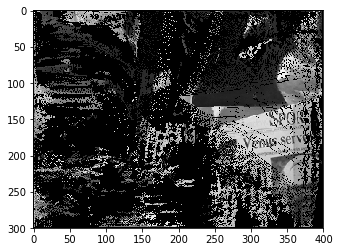

In [5]:
h, w = I2.shape
Iout = np.zeros((h, w))
d2 = {} 
d1 = {}
print("May take upto 10 min")
for i in range(len(epilines)):
    k = len(epilines)/10
    if(i%k==0):
        print((i/k)*10,"% done")
    epiline = epilines[i]
    vPts = validPoints(epiline, (h, w), 2)
    if len(vPts) == 0: 
        continue

    
    des = findDescriptors(I2, vPts, d2, listOfPoints)
    if des != None:
        ptI1 = listOfPoints[i]
        I1ptdes = findDescriptors(I1, [ptI1], d1, listOfPoints) 
        if I1ptdes != None:
            keys = list(des.keys())
            dis = np.array([des[key] for key in keys])
            temp = dis - I1ptdes[ptI1].astype(float)
            temp = np.linalg.norm(temp, axis=1)
            min_index = np.argmin(temp)
            argminKey = keys[min_index]
            y_ = argminKey[1]
            x_ = argminKey[0]
            y = ptI1[1]
            x = ptI1[0]
            Iout[y_,x_] = I1[y,x]
Iout = Iout.astype(np.uint8)
print("100.0 % done")
plt.imshow(Iout,cmap='gray')

In [6]:
cv2.imwrite('4.png',Iout)

True